In [14]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
from IPython.display import SVG



## Project Settings

Specified here are the paths for the data and the features to run over in the list of best features.
Each entry in the list is a list containing one single string of the features to try, comma seperated. In this way it is easy to write a script to 
add entries to try very easily. 

In [15]:

##### set parameters
path_train_data = 'train.csv'
path_test_data = 'test.csv'
path_all_data = 'Dataset Correlated Removed.csv'

# set features here

best_features = [
    ['nof_OH, nof_NH2, negCharge/Volume, posCharge/Volume, molPSA, molLogS'],
    ['nof_OH, nof_NH2, nof_Fragments, nof_negCharge, nof_posCharge, molPSA'],
    ['nof_OH, nof_SO3H, negCharge/Volume, posCharge/Volume, nof_posCharge, PSA/Area'],
    ['Sub Pathway, nof_OH, nof_NH2, negCharge/Volume, PSA/Area, molLogS'],
    ['nof_COOH, nof_SH, nof_SO3H, nof_negCharge, PSA/Area, molLogS'],
    ['nof_COOH, nof_SH, nof_SO3H, nof_PO4, negCharge/Volume, PSA/Area'],
    ['nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_posCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_negCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_posCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_negCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_SO3H, nof_Fragments, posCharge/Volume, molPSA'],
    ['nof_OH, nof_NH2, nof_SH, nof_Fragments, nof_posCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_SH, nof_Fragments, nof_negCharge, molPSA'],
    ['nof_OH, nof_NH2, nof_SH, nof_Fragments, posCharge/Volume, molPSA'],
    ['nof_OH, nof_NH2, nof_SH, nof_SO3H, nof_Fragments, molPSA'],
    ['nof_OH, nof_COOH, nof_NH2, nof_Fragments, nof_posCharge, molPSA']
]

best_features = [list(map(str.strip, x[0].split(','))) for x in best_features]

k = len(best_features)


## Load Dataset

This code loads dataset into the variables below and converts the labels to categorical 0, 1 pairs.

In [16]:
# load dataset
all_data = pd.DataFrame(pd.read_csv(path_all_data))
all_labels = all_data['SLC'].astype('category').cat.codes
# drop labels
all_data.drop('SLC', axis=1, inplace=True)

train_data = pd.DataFrame(pd.read_csv(path_train_data))
train_labels = train_data['SLC'].astype('category').cat.codes
# drop labels

train_data.drop('SLC', axis=1, inplace=True)

test_data = pd.DataFrame(pd.read_csv(path_test_data))
test_labels = test_data['SLC'].astype('category').cat.codes
# drop labels
test_data.drop('SLC', axis=1, inplace=True)


## AUC and Classification Accuracy - Decision Tree

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [17]:
# visualize decision tree for input features
''' HYPERPARAMS FOR DECISION TREE
 
 These parameters implement a rudimentary pruning algorithm, would ideally like to use AB pruning'''
enable_pruning = True
# maximum depth of dtree
max_depth = 5
# how many samples your need atleast, at a LEAF node
min_samples = 3

d_trees = []


# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
dt_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        dtree = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
        dtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])        
        pred = dtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    dt_cas.append(np.mean(aucs))
    

# find AUC 
dt_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
    clf.fit(subset_train_data, train_labels)
    d_trees.append(clf)
    
    # make its predictions on test data
    pred = d_trees[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    dt_aucs.append(auc)
    
print('Decision Tree Results:')
print('\tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(dt_aucs, dt_cas)):
    print('\t%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))

    

Decision Tree Results:
	AUC	Acc	Features
	0.786	0.687	nof_OH, nof_NH2, negCharge/Volume, posCharge/Volume, molPSA, molLogS
	0.821	0.743	nof_OH, nof_NH2, nof_Fragments, nof_negCharge, nof_posCharge, molPSA
	0.714	0.644	nof_OH, nof_SO3H, negCharge/Volume, posCharge/Volume, nof_posCharge, PSA/Area
	0.726	0.746	Sub Pathway, nof_OH, nof_NH2, negCharge/Volume, PSA/Area, molLogS
	0.726	0.698	nof_COOH, nof_SH, nof_SO3H, nof_negCharge, PSA/Area, molLogS
	0.726	0.674	nof_COOH, nof_SH, nof_SO3H, nof_PO4, negCharge/Volume, PSA/Area
	0.821	0.723	nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_posCharge, molPSA
	0.821	0.692	nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_negCharge, molPSA
	0.821	0.745	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_posCharge, molPSA
	0.821	0.716	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_negCharge, molPSA
	0.821	0.719	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, posCharge/Volume, molPSA
	0.821	0.751	nof_OH, nof_NH2, nof_SH, nof_Fragments, nof_posCharge, mo

## AUC and Classification Accuracy - Random Forest Walk

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [18]:
# visualize random forest features
rfws = []

# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
rfw_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        rfwtree = RandomForestClassifier(n_estimators=100)
        rfwtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])
        pred = rfwtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    rfw_cas.append(np.mean(aucs))
    

# find AUC 
rfw_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(subset_train_data, train_labels)
    rfws.append(clf)
    
    # make its predictions on test data
    pred = rfws[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    rfw_aucs.append(auc)

print('Random Forest Results:')
print('\tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(rfw_aucs, rfw_cas)):
    print('\t%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))


Random Forest Results:
	AUC	Acc	Features
	0.857	0.751	nof_OH, nof_NH2, negCharge/Volume, posCharge/Volume, molPSA, molLogS
	0.821	0.736	nof_OH, nof_NH2, nof_Fragments, nof_negCharge, nof_posCharge, molPSA
	0.869	0.729	nof_OH, nof_SO3H, negCharge/Volume, posCharge/Volume, nof_posCharge, PSA/Area
	0.869	0.767	Sub Pathway, nof_OH, nof_NH2, negCharge/Volume, PSA/Area, molLogS
	0.881	0.720	nof_COOH, nof_SH, nof_SO3H, nof_negCharge, PSA/Area, molLogS
	0.893	0.693	nof_COOH, nof_SH, nof_SO3H, nof_PO4, negCharge/Volume, PSA/Area
	0.821	0.740	nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_posCharge, molPSA
	0.786	0.759	nof_OH, nof_NH2, nof_Fragments, posCharge/Volume, nof_negCharge, molPSA
	0.833	0.737	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_posCharge, molPSA
	0.762	0.714	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, nof_negCharge, molPSA
	0.786	0.749	nof_OH, nof_NH2, nof_SO3H, nof_Fragments, posCharge/Volume, molPSA
	0.821	0.704	nof_OH, nof_NH2, nof_SH, nof_Fragments, nof_posCharge, mo

## Visualizing individual decision trees

The tree in variable `dtree` is visualized by the cell below. We can see how it is pruned, the splitting rule, etc.

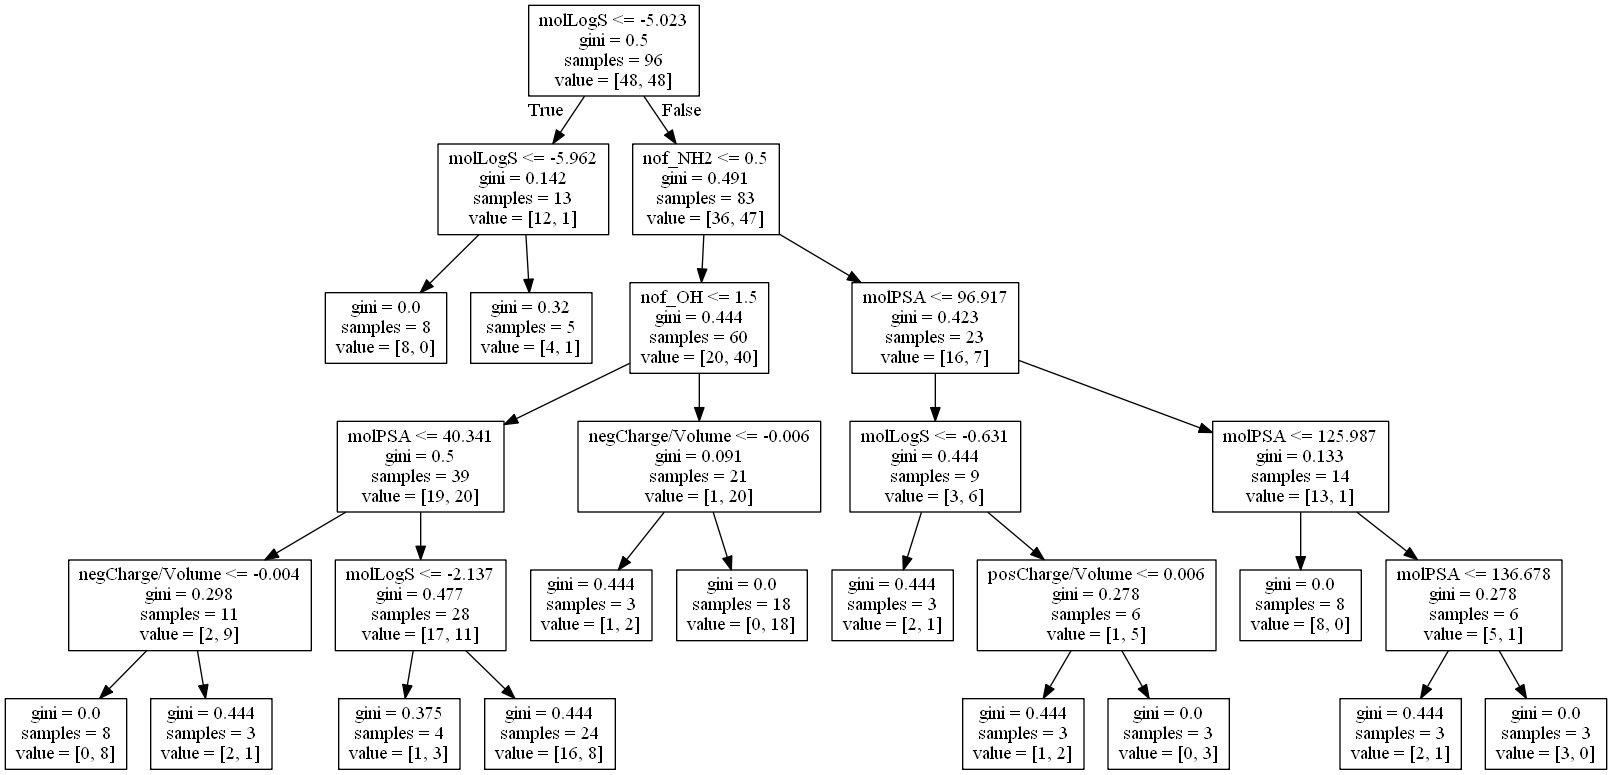

In [19]:
i = 0

dtree = d_trees[0]
graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
SVG(graph.pipe(format='svg'))            
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
graph.format = 'png'
graph.render('dtree_render',view=True)
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)
Image(png_bytes)

## Feature importance

The feature importances are compared below for decision trees and random forests.
Reported below is code to visualize all decision trees. This requires the graphviz package and has some bugs, which will be reported. This code visualizes all decision trees and finds the feature importances for all of them.

In [20]:
i = 0
# visualization
for dtree in d_trees:
    if i < k:
        print('Feature importances for tree and forest (resp.) %s/%s:' % (i + 1, k))
        for e in zip(dtree.feature_importances_, rfws[i].feature_importances_, best_features[i]):
            print('\t%6f\t%6f\t%s' % e)
        
        try:
            graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            SVG(graph.pipe(format='svg'))            
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            graph.format = 'png'
            graph.render('dtree_render',view=True)
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            png_bytes = graph.pipe(format='png')
            with open('dtree_pipe.png','wb') as f:
                f.write(png_bytes)
            Image(png_bytes)
        except:
            print('Something went wrong with rendering graph')
    else:
        print('Warning, code may be buggy')
    i += 1

Feature importances for tree and forest (resp.) 1/16:
	0.191344	0.090159	nof_OH
	0.158354	0.059798	nof_NH2
	0.091082	0.259637	negCharge/Volume
	0.012092	0.094078	posCharge/Volume
	0.263474	0.220918	molPSA
	0.283654	0.275411	molLogS
Something went wrong with rendering graph
Feature importances for tree and forest (resp.) 2/16:
	0.091416	0.113715	nof_OH
	0.220082	0.077717	nof_NH2
	0.304377	0.356994	nof_Fragments
	0.000000	0.057515	nof_negCharge
	0.000000	0.055120	nof_posCharge
	0.384125	0.338938	molPSA
Feature importances for tree and forest (resp.) 3/16:
	0.035681	0.103900	nof_OH
	0.000000	0.026040	nof_SO3H
	0.094807	0.290705	negCharge/Volume
	0.000000	0.112416	posCharge/Volume
	0.010293	0.039380	nof_posCharge
	0.859219	0.427559	PSA/Area
Feature importances for tree and forest (resp.) 4/16:
	0.000000	0.077649	Sub Pathway
	0.000000	0.077153	nof_OH
	0.046600	0.228676	nof_NH2
	0.790866	0.359024	negCharge/Volume
	0.162535	0.257498	PSA/Area
Feature importances for tree and forest (resp.) 5/1